<a href="https://colab.research.google.com/github/lorenafc/Capita_Selecta_RHI50403/blob/main/visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install libraries
!pip install cartopy -q
!pip install contextily -q
!pip install pyproj -q
!pip install matplotlib-scalebar -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 16.9 MB/s eta 0:00:00


In [2]:
#import libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import os
import imageio
import random
import re

from pyproj import Geod
from moviepy.editor import ImageSequenceClip
from shapely.geometry import Point, LineString
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches


In [3]:
# import and mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#upload the file
from google.colab import files
uploaded=files.upload()

Saving additional_authors_complete_geocoded_GoogleAPI_drive.xlsx to additional_authors_complete_geocoded_GoogleAPI_drive.xlsx


In [5]:
file_name = 'additional_authors_complete_geocoded_GoogleAPI_drive.xlsx'
authors_small_cities = pd.read_excel(file_name, engine='openpyxl')
authors_small_cities_copy=authors_small_cities.copy()


In [6]:
if 'bitrhyear' in authors_small_cities.columns:
    authors_small_cities = authors_small_cities.rename(columns={'bitrhyear': 'birthyear'})


In [7]:
def combine_geographic_data(df):
    """
    Combines geographic points data from birth, death, and active locations into a single GeoDataFrame,
    applies temporal filters, and adjusts coordinate reference systems.

    :param df: pd.DataFrame, the DataFrame containing geographic coordinates and temporal data.
    :return: gpd.GeoDataFrame, the combined and filtered GeoDataFrame with geographic and temporal adjustments.
    """
    # Create GeoSeries for birth, death, and active points
    birth_points = gpd.GeoSeries(
        [Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None for xy in zip(df['longitude_born'], df['latitude_born'])],
        crs="EPSG:4326"
    )
    death_points = gpd.GeoSeries(
        [Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None for xy in zip(df['longitude_death'], df['latitude_death'])],
        crs="EPSG:4326"
    )
    active_points = gpd.GeoSeries(
        [Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None for xy in zip(df['longitude_active'], df['latitude_active'])],
        crs="EPSG:4326"
    )

    # Combine birth, death, and active points into a single GeoSeries, prioritizing death points first, then active, then birth
    combined_points = death_points.fillna(active_points).fillna(birth_points)

    # Create a GeoDataFrame using the combined geometry column
    authors_geo_df = gpd.GeoDataFrame(df, geometry=combined_points)
    # Keep only rows where geometry is not null
    authors_geo_df = authors_geo_df[authors_geo_df.geometry.notnull()]

    # Convert 'birthyear' to numeric, coerce errors to NaN, prioritize death year, if missing, use birth year + 60
    authors_geo_df['birthyear'] = pd.to_numeric(authors_geo_df['birthyear'], errors='coerce')
    authors_geo_df['effective_year'] = authors_geo_df['deathyear'].fillna(authors_geo_df['birthyear'] + 60)

    # Set the CRS for the new GeoDataFrame and convert to a more suitable projection for mapping (Web Mercator)
    authors_geo_df = authors_geo_df.set_crs("EPSG:4326").to_crs(epsg=3857)

    # Filter the GeoDataFrame for records between the years 800 and 1800
    authors_geo_df = authors_geo_df[
        (authors_geo_df['effective_year'] >= 800) & (authors_geo_df['effective_year'] <= 1800)
    ].copy()

    return authors_geo_df




# Active Maps - Gif

- Authors in the map from 10 years before their death. When the year of death was not available it was considered the year of birth + 60.

- used active place when death place was not available, and birth place when active place was not available.

## WORLD

In [61]:
output_images_dir = "/content/drive/My Drive/your_folder/"
os.makedirs(output_images_dir, exist_ok=True)

# function to plot the maps
def plot_maps_per_year(startyear, endyear, gdf, output_images_dir):
    """
    Generates a series of maps showing authors' activity hotspots for each year within the specified range
    and saves the maps as PNG files.

    Parameters:
    startyear (int): The starting year for generating maps.
    endyear (int): The ending year for generating maps.
    gdf (GeoDataFrame): GeoDataFrame containing author data with columns for death year and geometry.
    output_images_dir (str): The directory where the output plot images will be saved.
    """
    # World boundaries in Web Mercator projection
    world_bounds = [-20037508.34, -8399737.88, 20037508.34, 10958014.95]

    # Invisible points to ensure full basemap is displayed
    invisible_points = gpd.GeoDataFrame({
        'geometry': [
            Point(-20037508.34, -20037508.34),  # Bottom left
            Point(20037508.34, -20037508.34),   # Bottom right
            Point(-20037508.34, 20037508.34),   # Top left
            Point(20037508.34, 20037508.34)     # Top right
        ],
        'point_count': [0, 0, 0, 0]
    }, crs="EPSG:3857")

    # Define a custom color map
    cmap = mcolors.ListedColormap(['#B0B0B0', '#8C8C8C', '#696969', '#4D4D4D', '#303030', '#000000'])
    bounds = [1, 2, 4, 6, 8, 10]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Function to determine opacity
    def get_opacity(count):
        if count >= 10:
            return 0.4  # 40% opacity
        elif count >= 4:
            return 0.6  # 60% opacity
        else:
            return 1.0  # No transparency

    # Loop through each year in the specified range
    for year in range(startyear, endyear + 1):
        # Create a string to represent the current year
        years = f"{year}"

        # Filter the GeoDataFrame for authors active in the timestep for 10 years prior to his/her death
        authors_active_timestep = gdf[
            (gdf['effective_year'] >= year) &
            (gdf['effective_year'] <= year + 10)
        ]

        # Check if there are any valid records for the current timestep
        if not authors_active_timestep.empty:
            # Group by unique points and get the count for each group and turn into GeoDataFrame
            unique_points_gdf = gpd.GeoDataFrame(
                authors_active_timestep.groupby('geometry').size().reset_index(name='point_count'),
                geometry='geometry'
            )

            # Ensure the CRS is set to EPSG:3857 for latitude and longitude
            unique_points_gdf = unique_points_gdf.set_crs(epsg=3857, allow_override=True)

            # Add invisible points to ensure full basemap is displayed
            unique_points_gdf = pd.concat([unique_points_gdf, invisible_points], ignore_index=True)

            # Add opacity column based on the point_count
            unique_points_gdf['opacity'] = unique_points_gdf['point_count'].apply(get_opacity)

            fig, ax = plt.subplots(figsize=(19, 10))

            # Plot the points with the custom color map and varying transparency
            unique_points_gdf.plot(
                ax=ax,
                column='point_count',
                cmap=cmap,
                norm=norm,
                markersize=unique_points_gdf['point_count'] * 30,
                aspect=0.7,
                alpha=unique_points_gdf['opacity'] )#,  # Use the opacity column here
                #edgecolor='black'
           #)

            # Add basemap with fixed zoom level
            cx.add_basemap(ax, attribution=False, zoom=2, crs=unique_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)

            # Tight layout
            fig.tight_layout(pad=3)

            # Labels inside the map
            ax.tick_params(direction="in")

            # Set plot limits to fixed geographic bounds
            ax.set_xlim(world_bounds[0], world_bounds[2])
            ax.set_ylim(world_bounds[1], world_bounds[3])

            # Set title and axis labels
            ax.set_title(f"Authors' Hotspots ({years})")
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

            # Set tick labels to show the Mercator projection coordinates
            ax.set_xticks([-20037508.34, -16697923.611, -13358339.89, -10018754.17, -6679169.45, -3339584.72, 0, 3339584.72, 6679169.45, 10018754.17, 13358339.89, 16697923.61, 20037508.34])
            ax.set_xticklabels(['', '', '120° W', '90° W', '60° W', '30° W', '0°', '30° E', '60° E', '90° E', '120° E', '150° E', ''])

            ax.set_yticks([-8399737.88, -5621521.48, -3503549.84, -1689200.13, 0, 1689200.13, 3503549.84, 5621521.48, 8399737.88, 10958014.95])
            ax.set_yticklabels(["", "45° S", '30° S', "15° S", '0°', "15° N", '30° N', "45° N", "60° N", ""])

            # Disable the grid lines
            ax.grid(False)

            # Adjust position of tick labels
            ax.tick_params(axis='x', pad=-15, labelsize=8)
            ax.tick_params(axis='y', pad=-30, labelsize=8)

            # Add the Projected Coordinate System
            ax.annotate("Projected Coordinate System:\n WGS 84 / Pseudo-Mercator", xy=(0.08, 0.04), ha="center", va="center", fontsize=8, xycoords=ax.transAxes)

            # Create a legend
            legend_handles = [
                mpatches.Patch(color="#B0B0B0", label="1 author"),     # Lightest Grey
                mpatches.Patch(color="#8C8C8C", label="2-3 authors"),  # Light Grey
                mpatches.Patch(color="#696969", label="4-5 authors"),  # Medium Grey
                mpatches.Patch(color="#4D4D4D", label="6-7 authors"),  # Dark Grey
                mpatches.Patch(color="#303030", label="8-9 authors"),  # Very Dark Grey
                mpatches.Patch(color="#000000", label="10+ authors")   # Black
            ]

            # Add the legend to the plot
            ax.legend(handles=legend_handles, loc='lower right')

            # North arrow
            x, y, arrow_length = 0.95, 0.95, 0.08
            ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                        arrowprops=dict(facecolor='black', width=5, headwidth=15),
                        ha='center', va='center', fontsize=20,
                        xycoords=ax.transAxes)

            # Save plot as .png file
            output_path = os.path.join(output_images_dir, f"active_hotspot_world_year_{years}.png")
            plt.savefig(output_path)
            plt.close(fig)  # Close the figure to avoid memory issues
            # plt.show()



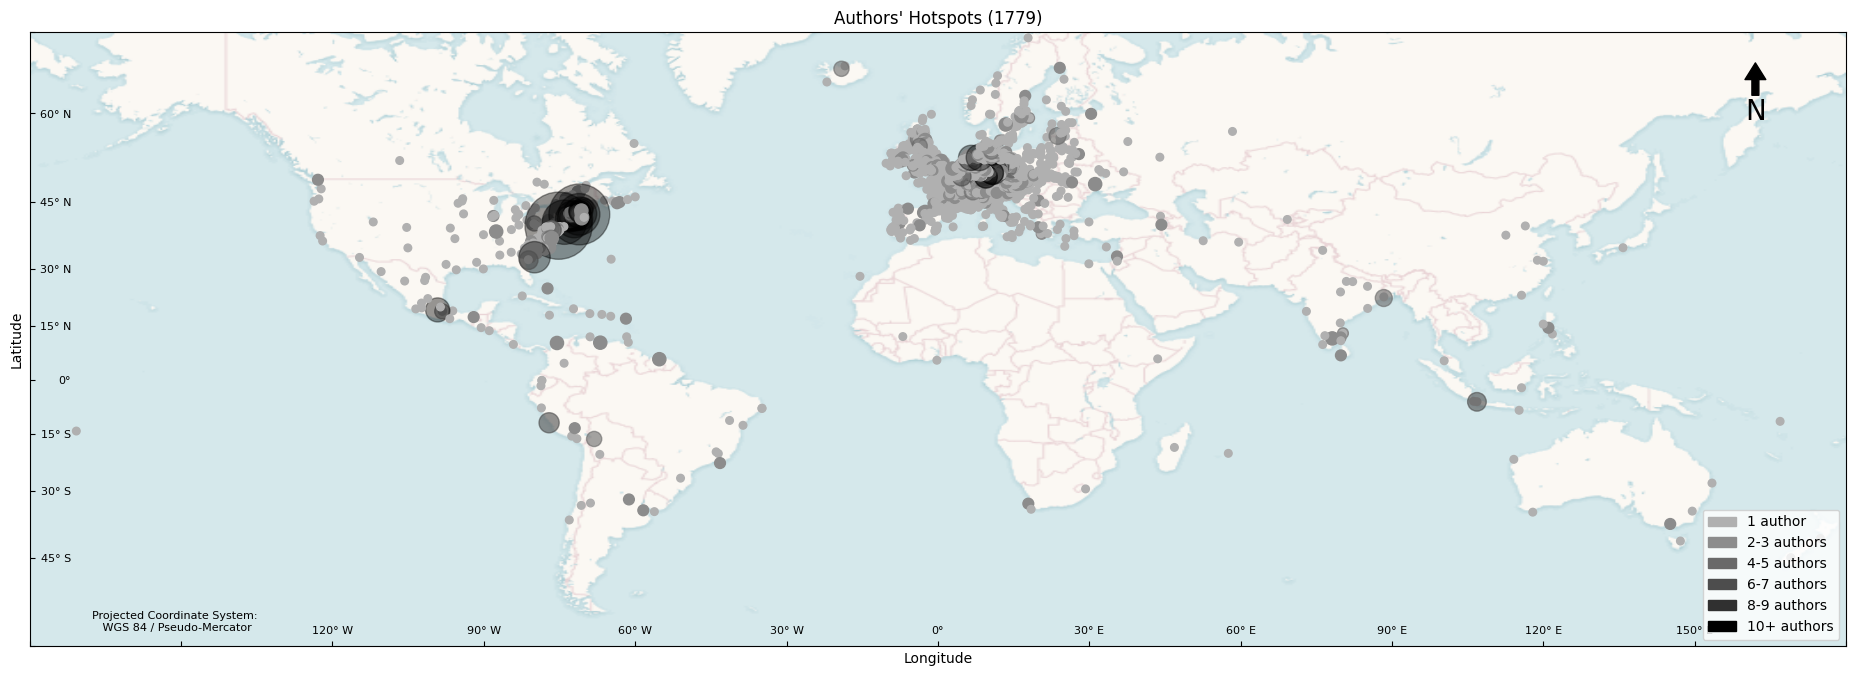

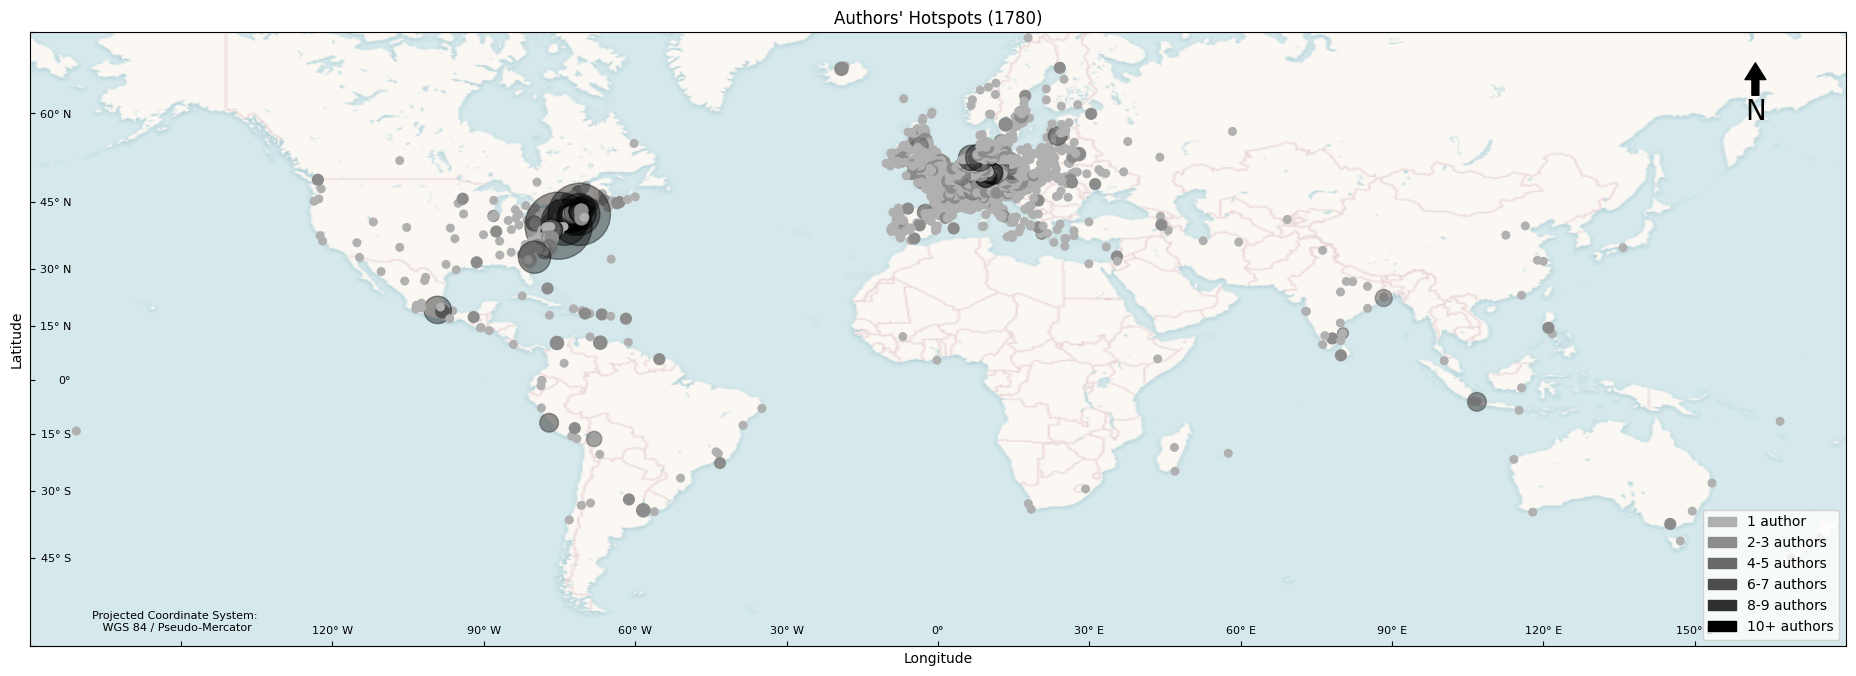

In [62]:
#plot world map
authors_gdf = combine_geographic_data(authors_small_cities)
plot_maps_per_year(1779, 1780, authors_gdf, "/content/drive/MyDrive/")

### Create Gif and Video

In [ ]:
### Create the gifs and video
#source: https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python and chat gpt


# Function to extract numerical values from filenames
def extract_number(file_name):
    match = re.search(r'(\d+)', file_name)
    return int(match.group(0)) if match else -1

# Path to the directory containing the images
image_dir = "/content/drive/My Drive/capita_selecta/gif_world_googleapi/" #update your path

# Check if the directory exists
if not os.path.exists(image_dir):
    print(f"The directory {image_dir} does not exist.")
else:
    print(f"Directory {image_dir} exists. Proceeding with file processing.")

    # List all the image files in the directory
    image_files = sorted(
        [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')],
        key=lambda x: extract_number(os.path.basename(x))
    )

    # Ensure the list is not empty
    if not image_files:
        print("No images found in the specified directory.")
    else:
        # Create a GIF (the gif works with 500 images but not with all of them on colab)
        gif_output_path = os.path.join(image_dir, 'authors_active_world.gif')
        images = [imageio.imread(file) for file in image_files]
        imageio.mimsave(gif_output_path, images, fps=25, loop=0)  # Adjust fps as needed
        print(f"GIF saved at {gif_output_path}")

        # Create a video
        video_output_path = os.path.join(image_dir, 'authors_active_world_googleapi.mp4')
        clip = ImageSequenceClip(image_files, fps=25)  # Adjust fps as needed
        clip.write_videofile(video_output_path, codec='libx264')
        print(f"Video saved at {video_output_path}")


Directory /content/drive/My Drive/capita_selecta/gif_world_googleapi/ exists. Proceeding with file processing.
No images found in the specified directory.


## EUROPE

In [53]:
#### EUROPE (using invisible points)

# source: Lucas Koren and ChatGPT


# Define the function without batch and step
def plot_maps_per_year_europe(startyear, endyear, authors_small_cities_combined, output_images_dir):

    """
    Generates a series of maps showing authors' activity hotspots for each year within the specified range in Europe and saves the maps as PNG files.
    Authors will be displayed for 10 years, including their year of death.

    Parameters:
    startyear (int): The starting year for generating maps.
    endyear (int): The ending year for generating maps.
    authors_small_cities_combined (GeoDataFrame): GeoDataFrame containing author data with columns for death year and geometry.
    output_images_dir (str): The directory where the output plot images will be saved.
    """

    os.makedirs(output_images_dir, exist_ok=True)

    # Europe boundaries in Web Mercator projection:
    world_bounds = [-1669792, 3503549.84, 3339584.72, 8399737.88]

    # Invisible points to ensure full basemap is displayed
    invisible_points = gpd.GeoDataFrame({
        'geometry': [
            Point(-20037508.34, -20037508.34),  # Bottom left
            Point(20037508.34, -20037508.34),   # Bottom right
            Point(-20037508.34, 20037508.34),   # Top left
            Point(20037508.34, 20037508.34)     # Top right
        ],
        'point_count': [0, 0, 0, 0]
    }, crs="EPSG:3857")

    # Define a custom color map
    cmap = mcolors.ListedColormap(['#B0B0B0', '#8C8C8C', '#696969', '#4D4D4D', '#303030', '#000000'])
    bounds = [1, 2, 4, 6, 8, 10]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Loop through each year in the range
    for year in range(startyear, endyear + 1):
        # Create a string to represent the current year
        years = f"{year}"

        # Filter the GeoDataFrame for authors active in the 10-year period before and including their death
        authors_active_timestep = authors_small_cities_combined[
            (authors_small_cities_combined['deathyear'] >= year) &
            (authors_small_cities_combined['deathyear'] <= year + 10)
        ]

        # Check if there are any valid records for the current year
        if not authors_active_timestep.empty:
            # Group by unique points and get the count for each group and turn into GeoDataFrame
            unique_points_gdf = gpd.GeoDataFrame(
                authors_active_timestep.groupby('geometry').size().reset_index(name='point_count'),
                geometry='geometry'
            )

            # Ensure the CRS is set to EPSG:3857 for latitude and longitude
            unique_points_gdf = unique_points_gdf.set_crs(epsg=3857, allow_override=True)

            # Add invisible points to ensure full basemap is displayed
            unique_points_gdf = pd.concat([unique_points_gdf, invisible_points], ignore_index=True)

            fig, ax = plt.subplots(figsize=(10, 9))

            # Plot the points with the custom color map
            unique_points_gdf.plot(ax=ax, column='point_count', cmap=cmap, norm=norm, markersize=unique_points_gdf["point_count"]*30, aspect=0.7, alpha=0.5)

            # Add basemap with fixed zoom level
            cx.add_basemap(ax, attribution=False, zoom=3, crs=unique_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)

            # tight layout
            fig.tight_layout(pad=3)

            # labels inside the map
            ax.tick_params(direction="in")

            # Set plot limits to fixed geographic bounds
            ax.set_xlim(world_bounds[0], world_bounds[2])
            ax.set_ylim(world_bounds[1], world_bounds[3])

            # Set title and axis labels
            ax.set_title(f"Authors' Hotspots ({years}) - Europe")
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

            ax.set_xticks([-1669792, 0, 1669792, 3339584.72])
            ax.set_xticklabels(['', '0°', '15° E', ''])

            ax.set_yticks([3503549.84, 5621521, 7361866, 8399737.88])
            ax.set_yticklabels(['', '45° N', '55° N', ''])

            # Disable the grid lines
            ax.grid(False)

            # Adjust position of tick labels
            ax.tick_params(axis='x', pad=-15, labelsize=8)
            ax.tick_params(axis='y', pad=-30, labelsize=8)

            # Create a legend
            legend_handles = [
                mpatches.Patch(color="#B0B0B0", label="1 author"),     # Lightest Grey
                mpatches.Patch(color="#8C8C8C", label="2-3 authors"),  # Light Grey
                mpatches.Patch(color="#696969", label="4-5 authors"),  # Medium Grey
                mpatches.Patch(color="#4D4D4D", label="6-7 authors"),  # Dark Grey
                mpatches.Patch(color="#303030", label="8-9 authors"),  # Very Dark Grey
                mpatches.Patch(color="#000000", label="10+ authors")   # Black
            ]

            # Add the legend to the plot
            ax.legend(handles=legend_handles, loc='lower right')

            # North arrow
            x, y, arrow_length = 0.95, 0.95, 0.08
            ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                        arrowprops=dict(facecolor='black', width=5, headwidth=15),
                        ha='center', va='center', fontsize=20,
                        xycoords=ax.transAxes)

            # Save plot as .png file
            output_path = os.path.join(output_images_dir, f"active_hotspot_europe_year_{years}_googleapi.png")
            plt.savefig(output_path)
            plt.close(fig)  # Close the figure to avoid memory issues
            # plt.show()



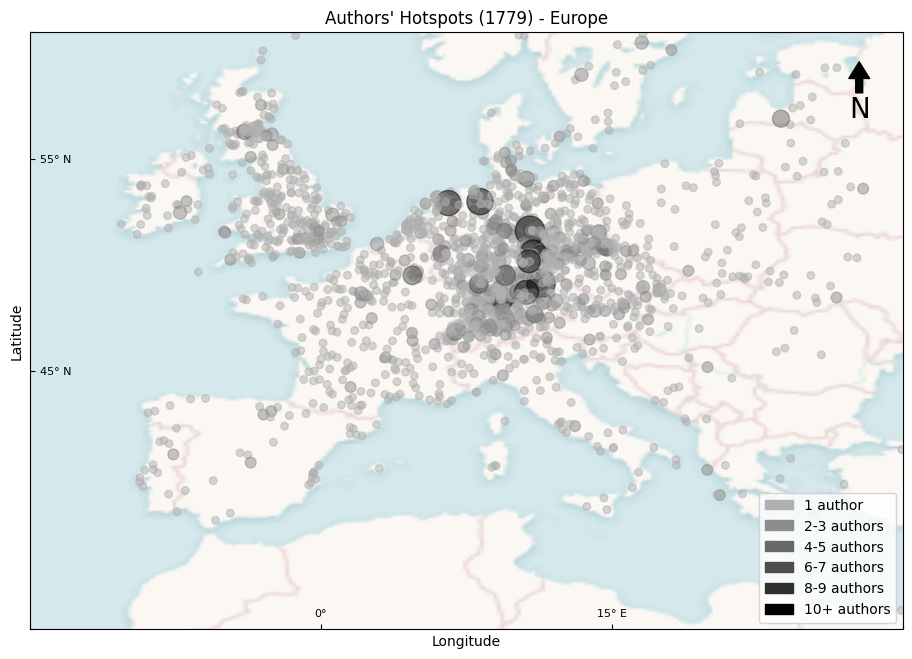

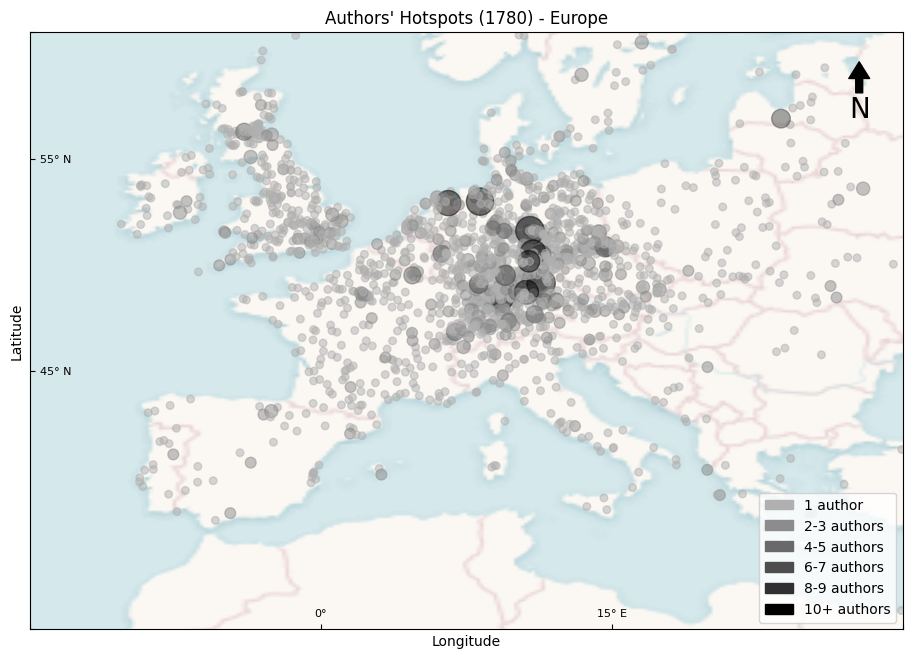

In [63]:
# plot Europe map
plot_maps_per_year_europe(1779, 1780, authors_gdf, "/content/drive/MyDrive/")

### Gif and Video - Europe

In [ ]:
### Create the gifs and video
#source: https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python and chat gpt

# Function to extract numerical values from filenames
def extract_number(file_name):
    match = re.search(r'(\d+)', file_name)
    return int(match.group(0)) if match else -1

# Path to the directory containing the images
image_dir = "/content/drive/My Drive/capita_selecta/gif_europe_googleapi/" #update your path

# Check if the directory exists
if not os.path.exists(image_dir):
    print(f"The directory {image_dir} does not exist.")
else:
    print(f"Directory {image_dir} exists. Proceeding with file processing.")

    # List all the image files in the directory
    image_files = sorted(
        [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')],
        key=lambda x: extract_number(os.path.basename(x))
    )

    # Ensure the list is not empty
    if not image_files:
        print("No images found in the specified directory.")
    else:
        # Create a GIF (the gif works with 500 images but not with all of them on colab)
        gif_output_path = os.path.join(image_dir, 'authors_active_europe.gif')
        images = [imageio.imread(file) for file in image_files]
        imageio.mimsave(gif_output_path, images, fps=30, loop=0)  # Adjust fps as needed
        print(f"GIF saved at {gif_output_path}")

        # Create a video
        video_output_path = os.path.join(image_dir, 'authors_active_europe_googleapi.mp4')
        clip = ImageSequenceClip(image_files, fps=30)  # Adjust fps as needed
        clip.write_videofile(video_output_path, codec='libx264')
        print(f"Video saved at {video_output_path}")


Directory /content/drive/My Drive/capita_selecta/gif_europe_googleapi/ exists. Proceeding with file processing.
Moviepy - Building video /content/drive/My Drive/capita_selecta/gif_europe_googleapi/authors_active_europe_googleapi.mp4.
Moviepy - Writing video /content/drive/My Drive/capita_selecta/gif_europe_googleapi/authors_active_europe_googleapi.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/My Drive/capita_selecta/gif_europe_googleapi/authors_active_europe_googleapi.mp4
Video saved at /content/drive/My Drive/capita_selecta/gif_europe_googleapi/authors_active_europe_googleapi.mp4


## North Sea region (NL, BE, UK)

In [64]:

def load_north_sea_data(file_name_ns, nl_shapefile, uk_shapefile, be_shapefile):
    """
    Loads the north sea data from an Excel file and combines shapefiles for the Netherlands, Belgium, and the UK.

    Parameters:
    file_name_ns (str): The path to the Excel file containing north sea data.
    nl_shapefile (str): The path to the Netherlands shapefile.
    uk_shapefile (str): The path to the UK shapefile.
    be_shapefile (str): The path to the Belgium shapefile.

    Returns:
    tuple: A DataFrame with north sea data and a combined GeoDataFrame of shapefiles.
    """
    # Load the north sea Excel file
    north_sea = pd.read_excel(file_name_ns, engine='openpyxl')

    # Load the shapefiles and convert them to the Web Mercator projection
    netherlands = gpd.read_file(nl_shapefile).to_crs(epsg=3857)
    belgium = gpd.read_file(be_shapefile).to_crs(epsg=3857)
    uk = gpd.read_file(uk_shapefile).to_crs(epsg=3857)

    # Combine the shapefiles into a single GeoDataFrame
    combined_shapefile = pd.concat([netherlands, belgium, uk])

    return north_sea, combined_shapefile



In [65]:
def prepare_geodata(authors_geo_df, combined_shapefile, north_sea):
    """
    Performs a spatial join to filter author points within the combined shapefile and prepares the north sea data for mapping.

    Parameters:
    authors_geo_df (GeoDataFrame): The GeoDataFrame containing author data. (it is the return of the function combine_geographic_data(df) )
    combined_shapefile (GeoDataFrame): The combined shapefiles for Netherlands, Belgium, and UK.
    north_sea (DataFrame): The DataFrame containing north sea data with longitude and latitude columns.

    Returns:
    tuple: A GeoDataFrame of authors within boundaries and a GeoDataFrame of north sea points in Web Mercator projection.
    """
    # Spatial join to filter points within the combined shapefile
    authors_within_boundaries = gpd.sjoin(authors_geo_df, combined_shapefile, predicate='within')

    # Convert the north sea data into a GeoDataFrame
    northsea_gdf = gpd.GeoDataFrame(
        north_sea, geometry=gpd.points_from_xy(north_sea.longitude, north_sea.latitude), crs="EPSG:4326"
    )

    # Convert the north sea GeoDataFrame to Web Mercator projection
    northsea_gdf = northsea_gdf.to_crs(epsg=3857)

    return authors_within_boundaries, northsea_gdf



In [66]:
def combine_year_columns(authors_within_boundaries, northsea_gdf):
    """
    Creates a unified 'year_plot' column for both small cities and big cities datasets,
    then combines them into a single GeoDataFrame.

    Parameters:
    authors_within_boundaries (GeoDataFrame): The GeoDataFrame of authors from small cities.
    northsea_gdf (GeoDataFrame): The GeoDataFrame of authors from big cities (North Sea region).

    Returns:
    GeoDataFrame: Combined GeoDataFrame with a unified 'year_plot' column.
    """
    # Create the 'year_plot' column for authors_within_boundaries (small cities)
    authors_within_boundaries['year_plot'] = authors_within_boundaries['effective_year']

    # Create the 'year_plot' column for northsea_gdf (big cities)
    northsea_gdf['year_plot'] = northsea_gdf['finalcedate']

    # Combine the two datasets by appending rows
    combined_authors = pd.concat([authors_within_boundaries, northsea_gdf], ignore_index=True) # I decided to leave the original columns names of the datasets
                                                                                                #and combined only the year columns in the "plot_year" column, instead
                                                                                                #of renaming the columns with same content.

    return combined_authors



In [67]:
def save_combined_authors_to_files(combined_authors, file_path_excel, file_path_csv):
    """
    Saves the combined GeoDataFrame to both Excel and CSV files.

    Parameters:
    combined_authors (GeoDataFrame): The combined GeoDataFrame of authors data.
    file_path_excel (str): Path where the Excel file will be saved.
    file_path_csv (str): Path where the CSV file will be saved.
    """
    # Save the GeoDataFrame as an Excel file
    combined_authors.to_excel(file_path_excel, index=False)

    # Save the GeoDataFrame as a CSV file
    combined_authors.to_csv(file_path_csv, index=False)



In [101]:
# source: chatGPT and Lucas Koren

# The Norh Sea boundaries in Web Mercator projection
world_bounds = [0, 6000000, 837000, 7500000]

# Invisible points to ensure full basemap is displayed
invisible_points = gpd.GeoDataFrame({
    'geometry': [
        Point(-20037508.34, -20037508.34),  # Bottom left
        Point(20037508.34, -20037508.34),   # Bottom right
        Point(-20037508.34, 20037508.34),   # Top left
        Point(20037508.34, 20037508.34)     # Top right
    ],
    'point_count': [0, 0, 0, 0]
}, crs="EPSG:3857")

# Define a custom color map with inverted greyscale
cmap = mcolors.ListedColormap(['#000000', '#303030', '#4D4D4D', '#696969', '#8C8C8C', '#B0B0B0'])
bounds = [1, 3, 6, 9, 12, 15]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Function to determine opacity
def get_opacity(count):
    if count >= 15:
        return 0.4
    elif count >= 9:
        return 0.6
    else:
        return 1.0

# Function to plot maps for each year
def plot_maps_per_year(startyear, endyear, combined_authors, northsea_gdf):
    for year in range(startyear, endyear + 1):
        # Filter the GeoDataFrame for authors active in the timestep for 10 years prior to their death
        # using the new unified 'year_plot' column
        authors_active_timestep = combined_authors[
            (combined_authors['year_plot'] >= year) &
            (combined_authors['year_plot'] <= year + 10)
        ]

        # Filter the northsea GeoDataFrame for points in the current year
        northsea_active_timestep = northsea_gdf[northsea_gdf['year_plot'] == year]

        # Combine both GeoDataFrames
        combined_active_timestep = pd.concat([authors_active_timestep, northsea_active_timestep])


        # Check if there are any valid records for the current year
        if not combined_active_timestep.empty:
            # Create a point_count column
            combined_active_timestep['point_count'] = 1

            # Group by unique points and get the count for each group and turn into GeoDataFrame  # source: https://sparkbyexamples.com/pandas/pandas-groupby-sum-examples/
            unique_points_gdf = combined_active_timestep.groupby('geometry').agg({'point_count': 'sum'}).reset_index()

            # Ensure the CRS is set to EPSG:3857 for latitude and longitude
            unique_points_gdf = gpd.GeoDataFrame(unique_points_gdf, geometry='geometry', crs='EPSG:3857')

            # Add invisible points to ensure full basemap is displayed
            unique_points_gdf = pd.concat([unique_points_gdf, invisible_points], ignore_index=True)

            # Add opacity column based on the point_count
            unique_points_gdf['opacity'] = unique_points_gdf['point_count'].apply(get_opacity)


            # Plotting
            fig, ax = plt.subplots(figsize=(19, 10))

            # Plotting the points
            unique_points_gdf.plot(
                ax=ax,
                column='point_count',
                cmap=cmap,
                norm=norm,
                markersize=unique_points_gdf['point_count']*10,
                alpha=unique_points_gdf['opacity'],
                edgecolor='black'
            )

            # Add basemap with fixed zoom level
            cx.add_basemap(ax, attribution=False, zoom=3, crs=unique_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)
            # Setting the bounds
            ax.set_xlim(world_bounds[0], world_bounds[2])
            ax.set_ylim(world_bounds[1], world_bounds[3])

            # Set title and axis labels
            ax.set_title(f"Authors' Hotspots - North Sea area (The Netherlands, Belgium and UK) in {year}")
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

            ax.set_xticks([-1669792, 0, 1113194])
            ax.set_xticklabels(['', '0°', ''])

            ax.set_yticks([6106854, 7361866, 8399737.88])
            ax.set_yticklabels(['', '55° N', ''])

            # Adjust position of tick labels
            ax.tick_params(axis='x', pad=-15, labelsize=8)
            ax.tick_params(axis='y', pad=-30, labelsize=8)

            # Adicione uma anotação
            ax.annotate("Projected Coordinate System:\n WGS 84 / Pseudo-Mercator", xy=(0.87,0.04), ha= "center", va="center", fontsize=8, xycoords= ax.transAxes)



            legend_handles = [
                mpatches.Patch(color="#000000", label="1-2 authors"),
                mpatches.Patch(color="#303030", label="3-5 authors"),
                mpatches.Patch(color="#4D4D4D", label="6-8 authors"),
                mpatches.Patch(color="#696969", label="9-11 authors"),
                mpatches.Patch(color="#8C8C8C", label="12-14 authors"),
                mpatches.Patch(color="#B0B0B0", label="15+ authors")
            ]


            # Add the legend to the plot
            ax.legend(handles=legend_handles, loc='lower left')

            x, y, arrow_length = 0.95, 0.95, 0.08
            ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                        arrowprops=dict(facecolor='black', width=5, headwidth=15),
                        ha='center', va='center', fontsize=20,
                        xycoords=ax.transAxes)

            # Saving the plot as an image
            output_image_path = os.path.join(output_images_dir, f'active_north_sea_{year}.png')
            plt.savefig(output_image_path)
            plt.close(fig)
            # plt.show()



In [87]:
# Load the North Sea data and combined shapefiles
file_name_ns = '/content/content/belgiumnetherlandsuk.xlsx'
nl_shapefile = '/content/content/nl.shp'
uk_shapefile = '/content/content/uk.shp'
be_shapefile = '/content/content/be.shp'

# Load the data
north_sea, combined_shapefile = load_north_sea_data(file_name_ns, nl_shapefile, uk_shapefile, be_shapefile)

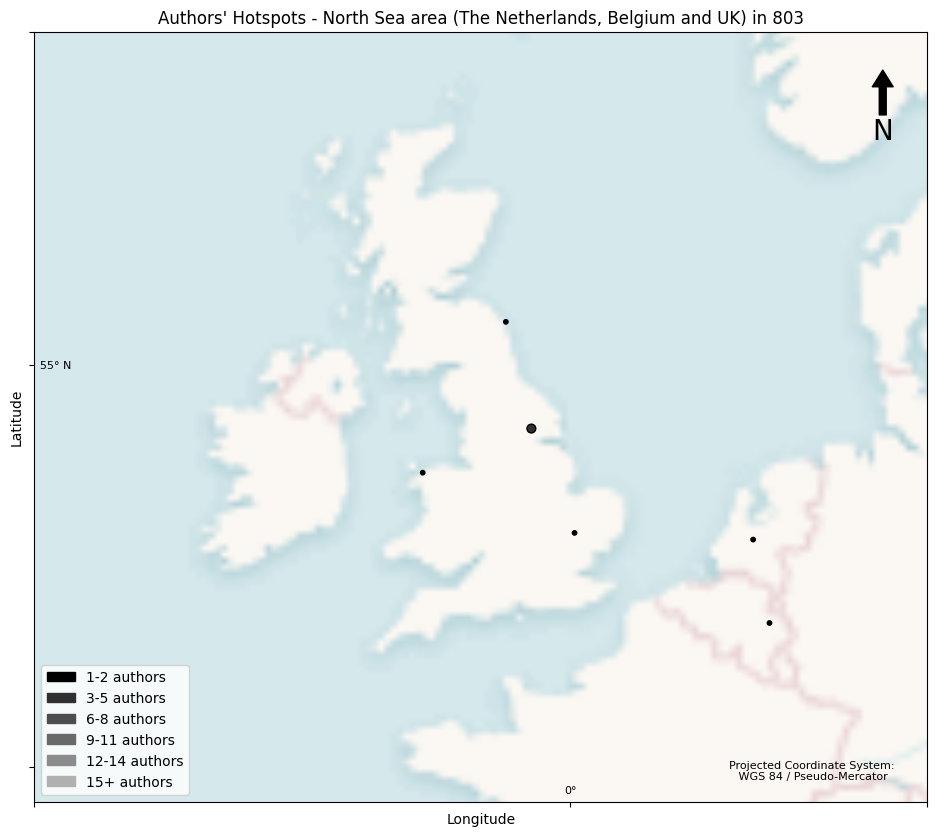

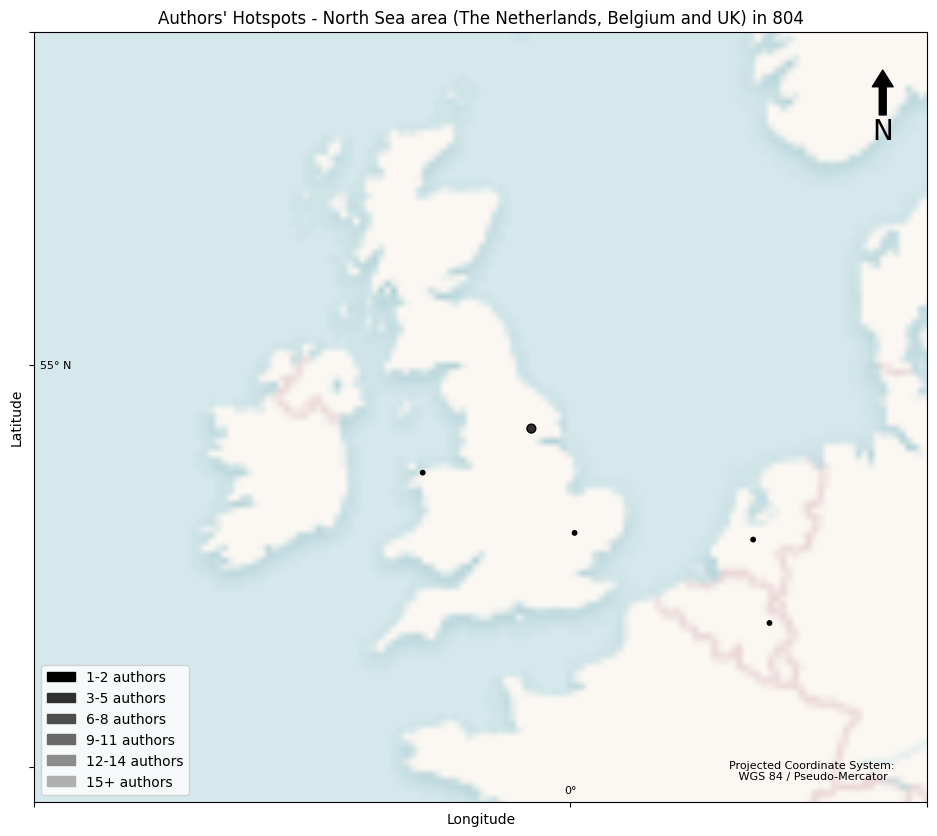

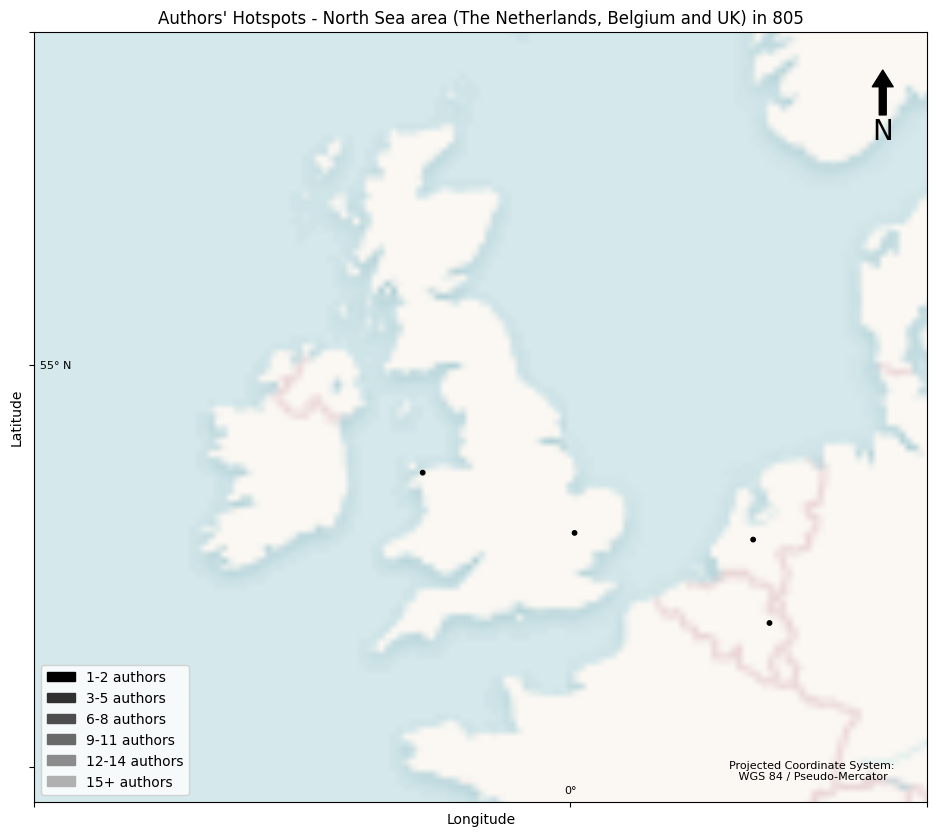

In [102]:

# Perform spatial join and get both authors_within_boundaries and northsea_gdf
authors_within_boundaries, northsea_gdf = prepare_geodata(authors_geo_df, combined_shapefile, north_sea)

# Combine year columns
combined_authors = combine_year_columns(authors_within_boundaries, northsea_gdf)

plot_maps_per_year(803, 805, combined_authors, northsea_gdf)

### Gif and Video Norh Sea

# Birth Death Map - 800-1800

### Due to places with same name in different locations, there are places geocoded incorrecly. Some places should be in Europe and were geocoded in the Americas and Oceania.

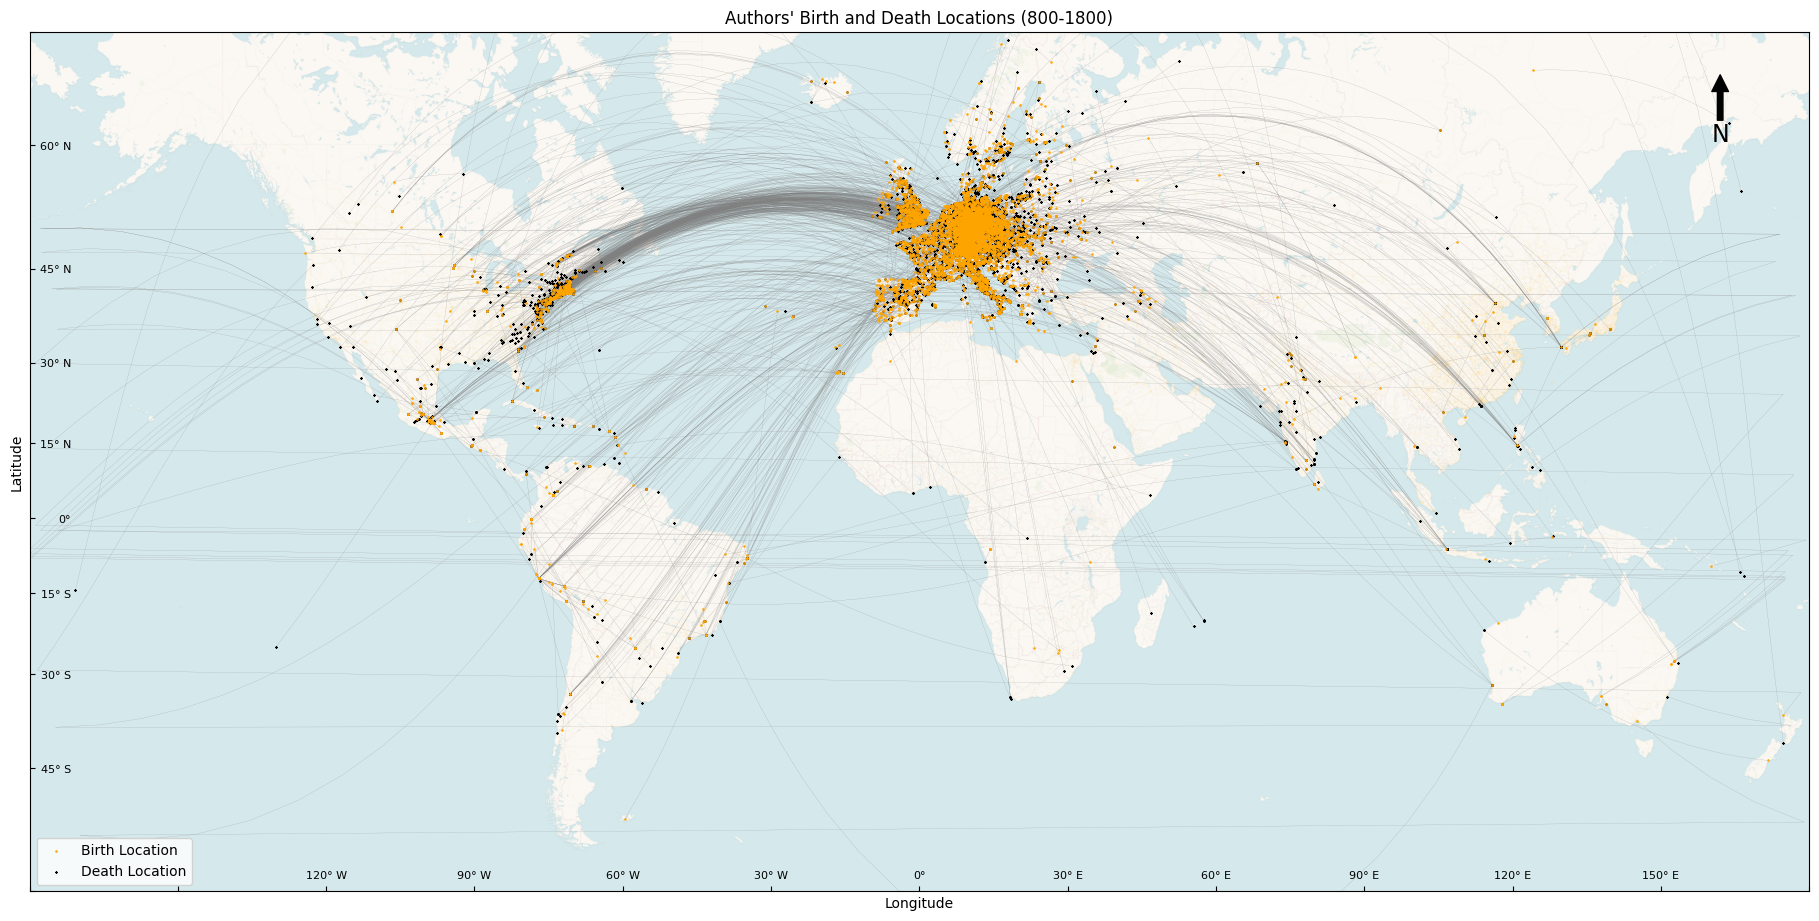

In [ ]:
# source: Lucas Koren and chatgpt

start_year = 800
end_year = 1800
output_dir = "/content/drive/My Drive/capita_selecta/active_maps/"

def plot_authors_birth_death(authors_df, start_year, end_year, output_dir):

    """
    Plots the birth and death locations of authors along with geodesic lines connecting these points on a map.

    Parameters:
    authors_df (DataFrame): DataFrame containing author data with columns for latitude and longitude of birth and death.
    start_year (int): The start year for filtering the authors.
    end_year (int): The end year for filtering the authors.
    output_dir (str): The directory where the output plot image will be saved.

    """
    # Filter years between start_year and end_year
    authors_df = authors_df[(authors_df['deathyear'] >= start_year) & (authors_df['deathyear'] <= end_year)]

    # Drop rows where the birth or death latitude/longitude is NaN
    authors_df = authors_df.dropna(subset=['latitude_born', 'longitude_born', 'latitude_death', 'longitude_death'])

    # Create Points for birth and death locations
    authors_df['birth_point'] = authors_df.apply(lambda row: Point(row['longitude_born'], row['latitude_born']), axis=1)
    authors_df['death_point'] = authors_df.apply(lambda row: Point(row['longitude_death'], row['latitude_death']), axis=1)

    # Create geodesic lines between birth and death points
    def create_geodesic_line(row):
        geod = Geod(ellps="WGS84")
        lon1, lat1 = row['longitude_born'], row['latitude_born']
        lon2, lat2 = row['longitude_death'], row['latitude_death']
        # Use npts method to calculate geodesic line
        points = geod.npts(lon1, lat1, lon2, lat2, 20) # Use npts to get intermediate points
        # Create a LineString from the calculated points
        return LineString([(lon1, lat1)] + points + [(lon2, lat2)])

    authors_df['line'] = authors_df.apply(create_geodesic_line, axis=1)

    # Create GeoDataFrames for points and lines
    birth_points_gdf = gpd.GeoDataFrame(authors_df, geometry='birth_point')
    death_points_gdf = gpd.GeoDataFrame(authors_df, geometry='death_point')
    lines_gdf = gpd.GeoDataFrame(authors_df, geometry='line')

    # Ensure the GeoDataFrame uses the WGS84 coordinate reference system
    birth_points_gdf.set_crs(epsg=4326, inplace=True)
    death_points_gdf.set_crs(epsg=4326, inplace=True)
    lines_gdf.set_crs(epsg=4326, inplace=True)

    # Convert to Web Mercator projection for plotting with basemap
    birth_points_gdf = birth_points_gdf.to_crs(epsg=3857)
    death_points_gdf = death_points_gdf.to_crs(epsg=3857)
    lines_gdf = lines_gdf.to_crs(epsg=3857)

    world_bounds = [-20037508.34, -8399737.88, 20037508.34, 10958014.95] # World boundaries

    fig, ax = plt.subplots(figsize=(19, 10))

    # Plot the birth points in orange
    birth_points_gdf.plot(ax=ax, color='orange', alpha=0.8, markersize=1, marker="*", zorder=3, label='Birth Locations')

    # Plot the death points in black
    death_points_gdf.plot(ax=ax, color='black', markersize=1, marker="x", zorder=2, label='Death Locations')

    # Plot the lines
    lines_gdf.plot(ax=ax, color='grey', linewidth=0.1, zorder=1)

    # Add basemap with fixed zoom level
    cx.add_basemap(ax, attribution=False, zoom=5, crs=birth_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)
    fig.tight_layout(pad=3)
    ax.tick_params(direction="in")

    # Disable the grid lines
    ax.grid(False)

    # Add legend
    plt.legend(['Birth Location', 'Death Location'], loc="lower left")

    # North arrow
    x, y, arrow_length = 0.95, 0.95, 0.07
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=4, headwidth=12),
                ha='center', va='center', fontsize=17,
                xycoords=ax.transAxes)

    # Set plot limits to fixed geographic bounds
    ax.set_xlim(world_bounds[0], world_bounds[2])
    ax.set_ylim(world_bounds[1], world_bounds[3])

    # Set title and axis labels
    ax.set_title("Authors' Birth and Death Locations (800-1800)")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Set tick labels to show the Mercator projection coordinates
    ax.set_xticks([-20037508.34, -16697923.611, -13358339.89, -10018754.17, -6679169.45, -3339584.72, 0, 3339584.72, 6679169.45, 10018754.17, 13358339.89, 16697923.61, 20037508.34])
    ax.set_xticklabels(['', '', '120° W', '90° W', '60° W', '30° W', '0°', '30° E', '60° E', '90° E', '120° E', '150° E', ''])

    ax.set_yticks([-8399737.88, -5621521.48, -3503549.84, -1689200.13, 0, 1689200.13, 3503549.84, 5621521.48, 8399737.88, 10958014.95])
    ax.set_yticklabels(["", "45° S", '30° S', "15° S", '0°', "15° N", '30° N', "45° N", "60° N", ""])

    # Disable the grid lines
    ax.grid(False)

    # Adjust position of tick labels
    ax.tick_params(axis='x', pad=-15, labelsize=8)
    ax.tick_params(axis='y', pad=-30, labelsize=8)

    # Save plot as .png file
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}/authors_birth_death_world_{start_year}-{end_year}.png")

    # Close the current figure to avoid overlapping plots
    plt.show()



plot_authors_birth_death(authors_small_cities_copy, start_year, end_year, output_dir)
